# Membrane Docking

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize
import chilife as xl

C:\Program Files\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get protein and membrane depth data
CPLA_C2 = xl.fetch('1bci').select_atoms('protein')
sites, depths = np.loadtxt('Membrane_depths.txt')

# Create labels and extract centroid
label_list = [xl.SpinLabel('R1M', site, protein= CPLA_C2, sample=1000) for site in sites]
spin_centroids = np.array([SL.spin_centroid for SL in label_list])

# Translate array of spin centroids to the origin for rotating
spin_at_ori = spin_centroids - np.mean(spin_centroids, axis=0)

# Create the objective function to fit Euler angles and membrane depth to the data
def objective(par):
    x, y, z, zdepth = par

    # Create a rotation matrix from the Euler angles
    R = Rotation.from_euler('xyz', [x, y, z])
    M = R.as_matrix()

    # Rotate and translate the spins
    spin_coords = spin_at_ori@M + np.array([0, 0, zdepth])

    # Compare the spin depth to the experimental depths and return the sum of squares error
    resid = spin_coords[:, 2] - depths
    return resid @ resid

fit = minimize(objective, x0=[0, 0, 0, 0], bounds=[[-180, 180], [-180, 180], [-180, 180], [-100, 100]])


  if atom_list == []:



In [3]:
# Move CPLA_C2 to the best fit location
R = Rotation.from_euler('xyz', fit.x[:3]).as_matrix()
CPLA_C2.atoms.positions = (CPLA_C2.atoms.positions - np.mean(spin_centroids, axis=0)) @ R + np.array([0, 0, fit.x[-1]])

# Move spin labels to new location and get the centroids for plotting
spin_centroids = np.empty_like(spin_centroids)
for i, SL in enumerate(label_list):
    SL.to_site(CPLA_C2.select_atoms(f'name N CA C and resid {SL.site}').positions)
    spin_centroids[i] = SL.spin_centroid


xl.save('C2_docked.pdb', *label_list, CPLA_C2, KDE=False)

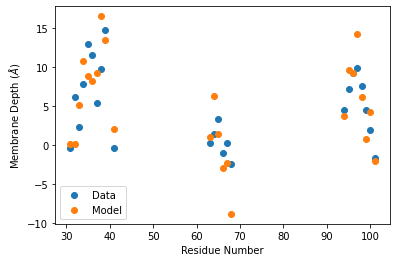

In [4]:
import matplotlib.pyplot as plt
plt.scatter(sites, depths, label='Data')
plt.scatter(sites, spin_centroids[:,2], label='Model')
plt.ylabel('Membrane Depth ($\AA$)')
plt.xlabel('Residue Number')
plt.legend()
plt.show()
